## Visualizations


In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import util
import config
from hydra import compose, initialize_config_dir
from data import (
    AudioDataloader,
    Librispeech,
    MSPPodcast,
    librispeech_collate_fn,
)
from models import DDDM, HifiGAN


In [2]:
def plot_mel(
    mels: torch.Tensor | list[torch.Tensor],
    title: str = "Mel-spectrogram",
    subtitle: list[str] = None,
) -> None:
    """Plot mel-spectrograms."""
    if not isinstance(mels, list):
        mels = [mels]
    n_mels = len(mels)
    fig, axes = plt.subplots(1, n_mels, figsize=(5 * n_mels, 5))
    if n_mels == 1:
        axes = [axes]
    for i, mel in enumerate(mels):
        axes[i].imshow(mel[0].detach().cpu().numpy(), aspect="auto", origin="lower")
        axes[i].set_title(subtitle[i] if subtitle else f"{title} {i+1}")
        axes[i].set_xlabel("Frames")
        axes[i].set_ylabel("Channels")
    plt.tight_layout()
    plt.show()

## Configurations

In [3]:
CONFIG_NAME = "vc_config.yaml"
TESTING_DATASET = "msp-podcast"  # "librispeech"

# set default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
config.register_configs()
with initialize_config_dir(
    version_base=None, config_dir=config.CONFIG_PATH.as_posix()
):
    cfg = compose(config_name="config_vc.yaml")
cfg = cfg._to_object()

In [7]:
cfg.data.dataset

DatasetConfig(name='MSP-Podcast', path='D:/DDDM-EVC/datasets/msp-podcast/', sampling_rate=16000, segment_size=76000)

In [8]:
if TESTING_DATASET == "librispeech":
    dataset = Librispeech("dev-clean", "LibriSpeech")
    dataloader = AudioDataloader(
        dataset=dataset, cfg=cfg, collate_fn=librispeech_collate_fn
    )
elif TESTING_DATASET == "msp-podcast":
    dataset = MSPPodcast(cfg.data, split="development")
    dataloader = AudioDataloader(
        dataset=dataset, cfg=cfg, collate_fn=librispeech_collate_fn
    )
else:
    raise ValueError(f"Unknown dataset: {TESTING_DATASET}")

In [9]:
vocoder = HifiGAN(cfg.model.vocoder)
vocoder.requires_grad_(False)
vocoder.to(device)
util.load_model(vocoder, "hifigan.pth")
print("Vocoder loaded successfully.")

Vocoder loaded successfully.


In [10]:
model = DDDM(cfg.model, sample_rate=cfg.data.dataset.sampling_rate)
model.to(device)
model.load_pretrained(freeze=True, device=device)


In [11]:
x, x_mel, x_n_frames = next(iter(dataloader))
x, x_mel, x_n_frames = util.move_to_device((x, x_mel, x_n_frames), device)

y_mel, enc_out = model(x, x_mel, x_n_frames, return_enc_out=True)

D:\DDDM-EVC\.venv\lib\site-packages\amfm_decompy\pYAAPT.py:970: RuntimeWarning: divide by zero encountered in divide
  phi[lag_min:lag_max] = formula_nume/np.sqrt(formula_denom)


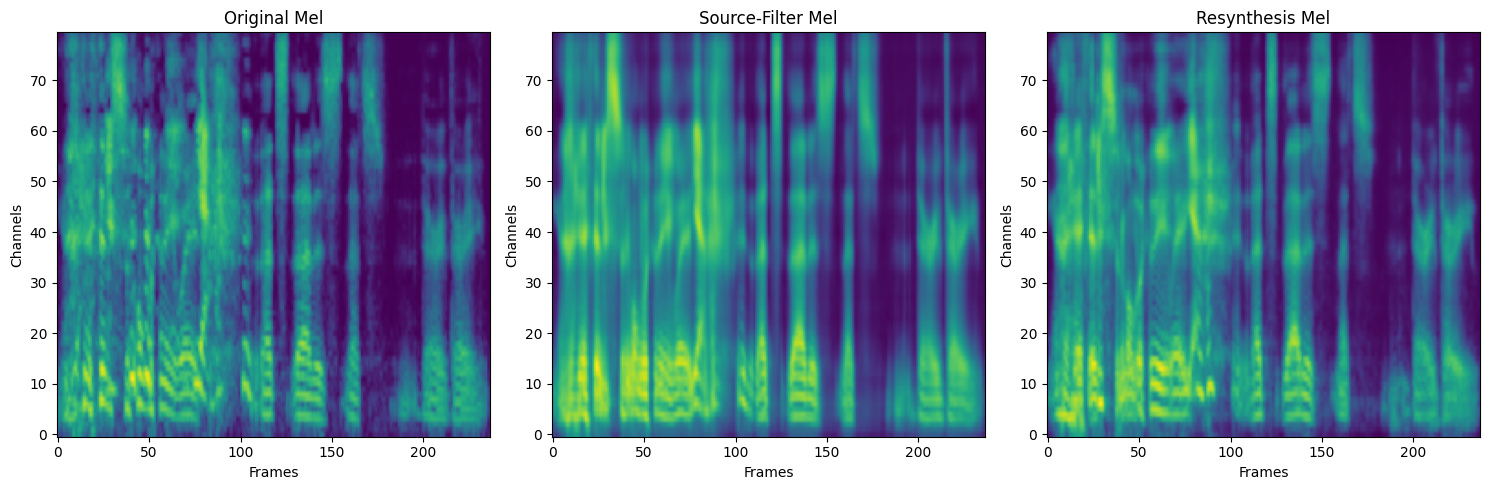

In [12]:
x_audio = vocoder.infer(x_mel)
enc_audio = vocoder.infer(enc_out)
y_audio = vocoder.infer(y_mel)

plot_mel(
    [x_mel, enc_out, y_mel],
    title="Spectrograms",
    subtitle=["Original Mel", "Source-Filter Mel", "Resynthesis Mel"]
)

display(
    Audio(x_audio[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate),
    Audio(enc_audio[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate),
    Audio(y_audio[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate),
)

In [15]:
x, x_mel, x_n_frames = next(iter(dataloader))
tgt, tgt_mel, tgt_n_frames = next(iter(dataloader))
x, x_mel, x_n_frames = util.move_to_device((x, x_mel, x_n_frames), device)
tgt_mel, tgt_n_frames = util.move_to_device((tgt_mel, tgt_n_frames), device)

y_mel, enc_out = model.voice_conversion(
    x, x_mel, x_n_frames,
    y_mel=tgt_mel,
    y_n_frames=tgt_n_frames,
    return_enc_out=True
)

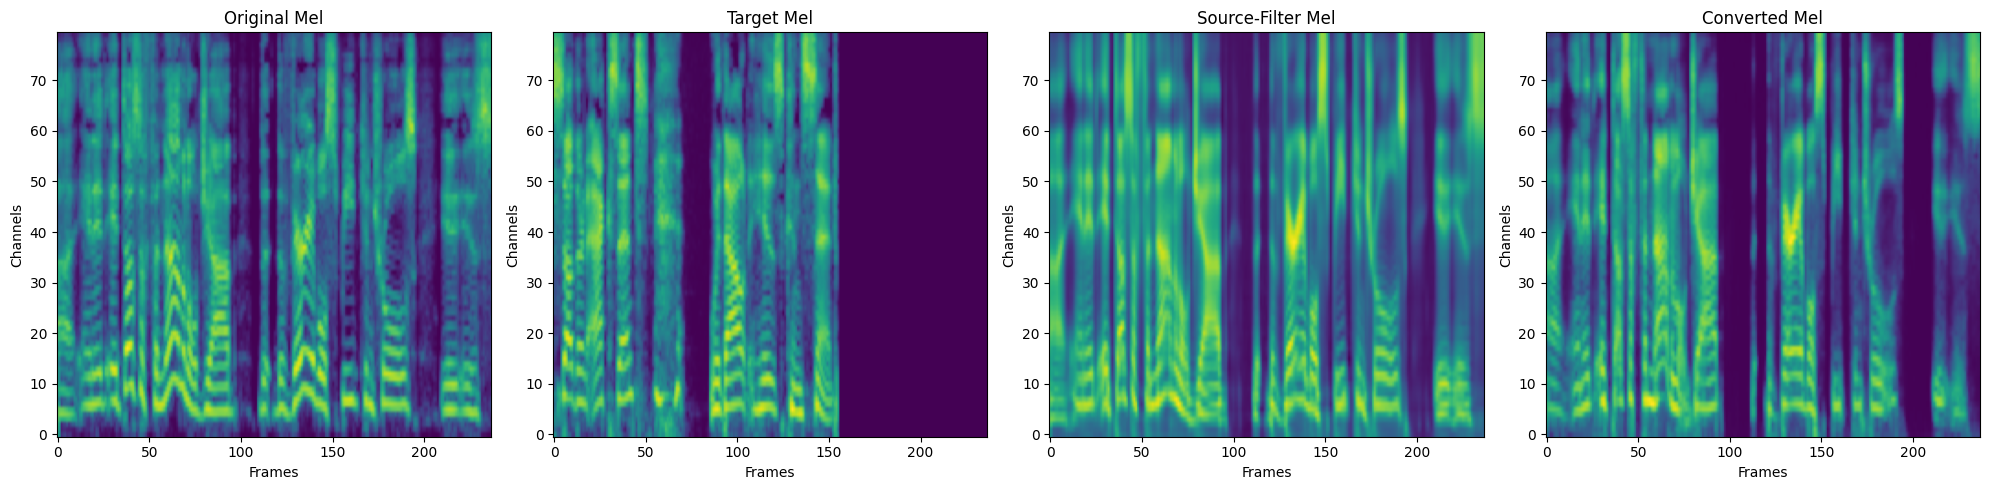

In [16]:
x_audio = vocoder.infer(x_mel)
tgt_audio = vocoder.infer(tgt_mel)
enc_audio = vocoder.infer(enc_out)
y_audio = vocoder.infer(y_mel)

plot_mel(
    [x_mel, tgt_mel, enc_out, y_mel],
    title="Spectrograms",
    subtitle=["Original Mel", "Target Mel", "Source-Filter Mel", "Converted Mel"]
)

display(
    Audio(x_audio[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate),
    Audio(tgt_audio[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate),
    Audio(enc_audio[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate),
    Audio(y_audio[0].detach().cpu().numpy(), rate=cfg.data.dataset.sampling_rate),
)